# Markov chains
In this Lab we learn how to simulate discrete and continuous time Markov chains.

## A first example: Random Walks on graphs and the flow dynamics
In this section study a first example of discrete time Markov chain, which is the simple random walk on a graph, and we analyse the connection between random walks and the flow dynamics.

To explore such connections we first learn how to simulate a random walk.

### Simple Random Walk

A random walker on a graph $\mathcal G$ is an agent that starts at the initial time $0$ at some node and at each time moves from the current position to a neighboring one, chosen with uniform probability.

To learn how to simulate a random walk, here we consider the example of a $n \times n$ chessboard with a single knight on it. 
1. We construct a network $G$ with all knight's possible moves. In this network nodes represent chessboard locations and an edge between two locations is present if the knight is admitted to move from one to another. (Note that the resulting graph is undirected).
2. We implement a simulation of the knight's random walk on the chessboard network $G$.

In [1]:
import networkx as nx
import numpy as np
from numpy.random import choice, rand 

#### The Knight's Network

Here we define function `GenerateKnightNetwork` that constructs the knight's network. 
It exploits two auxiliary functions, `ApplyLegalMoves` and `isLegalPos`.

In [2]:
# Generates the graph representing the knigth network.
# Return both the graph object G and the pos dictionary
# for drawing G.

def GenerateKnightNetwork(boardSize):
    # undirected graph G will store the knight's network
    G = nx.Graph()
    # when drawing G, the pos dictiornary describes the position on 
    # a boardsize x boardsize grid where to place nodes
    pos = {}
    
    for row in range(boardSize):
        for column in range(boardSize):
            node_id = row + column*boardSize
            # pos[node_id] are the (x,y) coordinates of node node_id 
            # on a square grid of side boardSize
            pos[node_id] = np.array([1.0*row/boardSize, 1.0*column/boardSize])
            
            # compute the (row,column) of neighboring position to the
            # current one, i.e., positions on the chessoboard reachable
            # by applying legal moves
            neigh_pos = ApplyLegalMoves(row, column, boardSize)
            # for each neigbhoring position, compute the id and add
            # a link in G from current position node_id to neigh_id
            for p in neigh_pos:
                neigh_id = p[0] + p[1]*boardSize
                G.add_edge(node_id, neigh_id)
    return G, pos


# Apply the knight's legal moves to the current position to construct
# neighboring nodes in the knight's graph

def ApplyLegalMoves(x,y,boardSize):
    # will store the neighboring nodes
    new_positions = []
    
    # offsets describe the effect of the knight's legal moves
    # on the current position's row and column
    offsets = [(-1,-2),(-1,2),(-2,-1),(-2,1),
                   ( 1,-2),( 1,2),( 2,-1),( 2,1)]
    
    # for each legal move, compute the new position's row and column
    for off in offsets:
        new_x = x + off[0]
        new_y = y + off[1]
        
        # if the new position doesn't exceed the boardsize,
        # accept it as legal
        if isLegalPos(new_x,boardSize) and isLegalPos(new_y,boardSize):
            new_positions.append((new_x,new_y))
         
    return new_positions

# Determines if the position obtained applying a move is legal,
# i.e. if it is inside the chessboard
def isLegalPos(x,boardSize):
    if x >= 0 and x < boardSize:
        return True
    else:
        return False

We are now ready to generate an example of the knight's network, with a specified boardsize.

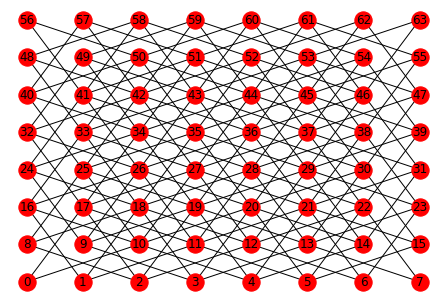

In [6]:
boardSize = 8
(G,pos) = GenerateKnightNetwork(boardSize)
nx.draw(G,pos, with_labels=True, node_color='red')

#### Simulate the Random Walk Process
Now that we have the graph $G$ representing the knight's network, we can simulate the knight's random walk on it. 

The walk starts at some given node and it can either terminate after a specified number of steps or when it first returns to the starting node.

At each step, the walker is at some node `xi` and has to decide which node to visit next. 

In this simple version of the random walk, he does it by chosing a neighbor of the current node uniformly at random.
More formally, he looks at row `xi` of the normalized weight matrix $P$ of the graph $G$ and interprets the nubers on that row as the probability of visiting the corresponding nodes next, given that he currently is at `xi`.

To simulate the random walk we define the function `RandomWalk`, which allows to specify the graph $G$ on which the walk takes place, the starting node and the stopping criterion.

**Remark 1**: the `RandomWalk` function is independent on the specific example we are studying. In other words, it allows to simulate any simple random walk on any **unweighted** graph $G$, since it only exploits the general features of the stochastic process at hand.

In [5]:
# Simulates a random walk on the graph G, starting from node xi.
# if till_first_return = True the random walk stops the first time
# it returns to the starting node xi.
# Otherwise, it goes on for num_steps steps.

def RandomWalk(G, xi, num_steps, till_first_return = False):
    # nodeSeq stores the sequence of visited nodes
    nodeSeq = []
    nodeSeq.append(xi)
    
    # if the walk ends at the first return to xi
    if till_first_return:
        # stores the initial position to check if the 
        # walk returns to it
        x_init = xi
        
        while True:
            # compute the next visited node xi by chosing uniformly
            # at random a neighbor of the current one
            xi = choice(G.adj[xi],1)[0]      
            nodeSeq.append(xi)
            
            # check if the walk has returned to the starting node
            # if so, end the walk
            if xi == x_init:
                return nodeSeq
    
    # if the walk ends after num_steps steps
    else:
        for i in range(num_steps):
            xi = choice(G.adj[xi],1)[0]      
            nodeSeq.append(xi)
        return nodeSeq


As a first experiment, we simulate a simple random walk on $G$ with $100$ steps.

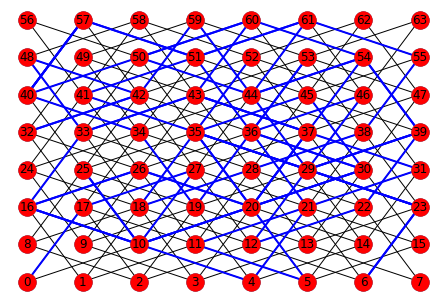

In [7]:
# Simulate a random walk on G 
nodeSeq = RandomWalk(G, xi=0, num_steps=100, till_first_return=False)
edgeSeq = [(nodeSeq[i-1], nodeSeq[i]) for i in range(1,len(nodeSeq))]

# Draw G and represent the random walk by colouring the edge sequence
# first draw all nodes and links
nx.draw(G, pos)
# then, on the previous picture, add node labels and highlight the edge sequence
nx.draw(G, pos, with_labels=True, edgelist = edgeSeq, edge_color='blue', node_color='red', width=2)

### Random Walks and the Flow Dynamics

The random walk and the flow dynamics are deeply connected. Indeed, if we describe the position of the walker on $G$ at time $t$ with a random variable $x(t)$, the variable's probability distribution evolves according to the flow dynamics:
$$
x(t+1) = P'x(t)
$$
or more explicitly
$$
x_j(t+1) = \sum_{i \in \mathcal V} P_{ij}x_i(t)
$$
Moreover, one can use a random walk to estimate the invariant measure $\pi$ of the graph $G$ (assume here $G$ is strongly connected). Indeed, by the Katz theorem, the fraction of time spent by the walker on each node tends to the node's value in the invariant measure $\pi$ as the length of the walk increases.

The following section shows how to compute empirical frequencies and how to compare them with the inviariant distribution of $G$.

#### Empirical frequencies and invariant distribution
The empirical frequencies are the fractions of total walk time that each node of G is visited in the random walk. 

They can be represented by an histogram as follows.

We simulate random walks starting at each node of $G$, and we keep trace of the sequence of visited nodes. 

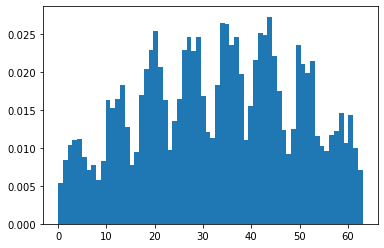

In [10]:
import matplotlib.pyplot as plt

# nodeSeq: list to store all random walks
nodeSeq = []

# simulate one random walk for each initial node in G
for xi in range(G.number_of_nodes()):
    # list.extend extends the list by appending all the items from an iterable
    nodeSeq.extend(RandomWalk(G, xi, 100))
    
# plt.hist computes and draws the histogram of nodeSeq. We have one bin for each node,
# so each bin width is 1 and the number of observations in each bin equals the number
# of visits to the correspnding node. 
# Since density=True, the return element will be the counts normalized 
# to form a probability density.
h = plt.hist(nodeSeq, bins = G.number_of_nodes(), density=True)

In order to use empirical frequencies to approximate the invariant measure of $G$, we have to construct a long random walk. As an example, here we run a random walk with $1000$ steps.

In [11]:
# Simulate a "long" random walk

nodeSeq = RandomWalk(G, 0, 1000, False)


# Compute empirical frequencies

frequencies = np.zeros(len(G))
# count the visits to each node
for node in nodeSeq:
    frequencies[node] += 1
# normalize the counts to obtain frequencies
frequencies /= len(nodeSeq)
print("Frequencies:", frequencies)


# Compute P matrix
A = nx.adjacency_matrix(G) # -> return type is scipy.sparse.csr_matrix
A = A.toarray() # convert A to a numpy array
degrees = np.sum(A,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ A

# Compute invariant distribution
values,vectors = np.linalg.eig(P.T)
index = np.argmax(values.real)
pi = vectors[:,index].real
pi = pi/np.sum(pi)
print("pi=", pi)

# Evaluate the approximation error by computing the norm of
# the difference between the empirical frequencies and the 
# invariant measure
error = np.linalg.norm(frequencies-pi)
print("Error", error)

Frequencies: [0.00699301 0.003996   0.01398601 0.01398601 0.01598402 0.01398601
 0.01498501 0.00699301 0.01298701 0.00799201 0.01398601 0.01598402
 0.01998002 0.01998002 0.01898102 0.01098901 0.004995   0.01598402
 0.02797203 0.02897103 0.02797203 0.03396603 0.01698302 0.01998002
 0.01198801 0.01998002 0.01798202 0.01798202 0.02197802 0.02797203
 0.01798202 0.01498501 0.00899101 0.01398601 0.02397602 0.02197802
 0.01998002 0.02097902 0.02497502 0.00899101 0.01198801 0.00999001
 0.01298701 0.01998002 0.03196803 0.02797203 0.01598402 0.01098901
 0.000999   0.00899101 0.01298701 0.01598402 0.01498501 0.02297702
 0.01098901 0.01098901 0.         0.00999001 0.00599401 0.01298701
 0.01298701 0.01598402 0.00899101 0.00899101]
pi= [0.00595238 0.01785714 0.01785714 0.00892857 0.01785714 0.01190476
 0.02380952 0.01190476 0.00892857 0.01785714 0.02380952 0.01190476
 0.01190476 0.01785714 0.02380952 0.01190476 0.01190476 0.02380952
 0.01190476 0.00892857 0.01785714 0.00892857 0.01190476 0.00595238

### Exercise
Consider the graph shown in the following picture:
![Exgraph](graph1.png)
**Remark 2**: for nodes without out-going links, follow the convention and add a self-loop.

1. For each node of $G$, simulate the simple random walk starting from that node. What do you observe? How can you justify your observations?
2. Study the graph $G$ and compute its invariant measures. Can you see any relation with the behavior of the random walk?
3. Substitute the link (5,1) with the link (1,5) and repeat the analysis performed at point 1. and 2. What topological property of the graph has changed? How does this reflect on the random walk process?


In [ ]:
# TO DO

## Discrete time Markov chains
We already saw an example of discrete time Markov chain: the random walk on the knight's network.

In general, every discrete time Markov chain can be interpreted as a random walk on a weighted directed graph. So, in the general case, transition probabilities from each node to its neighbors are not uniformly distributed.

To better understand this notion, we analyse the following example.

![DMCgraph](discreteMC.png)

1. Construct the directed graph G with weights as shown in the picture.
2. Compute the invariant probability distribution vector by computing the leading eigenvector of P'
3. Simulate a random walk starting from node 1 on the graph for n = 1000, 2000, 5000, 10000 steps. Determine the fraction of the steps the walk has been in each node i. Compare this with the invariant distribution. What do you observe?

**Hint:** you can adopt the function RandomWalk by modifying the choice of the next node to visit according to the fact that the transition probability is not unifrom.

4. What happens with your estimate of $\pi$ if you remove node 5 and all links connected to it from the graph and add a self loop of weight 1 to node 6?
5. Compute the expected hitting time $\mathbb{E}_j[T_S]$, $\forall j \in R = \mathcal V \setminus \mathcal S$, for the set $S = \{2, 5\}$ analytically.
6. For every node i, simulate several times a random walk on G that begins in node i and stops when it comes back to it. Use this simulation to estimate the expected return time, $\mathbb{E}_i[T_i^+]$. Compare this estimate with the expected return times obtained analytically from the expected hitting times.


1.- 3.

In [ ]:
# TODO

4. If node 5 is removed, node 6 is a sink node. Hence, all random walks will eventually reach this node so that the estimate of the invariant measure will converge to $\pi =[ 0 0 0 0 1 ]^T$. You can check this by simulating the random walk on the modified graph.

In [ ]:
# TODO

5. The expected hitting times  $\hat{x}= (\mathbb{E}_i[T_S])_{i \in R}$ for the set $S$ and for all nodes $i \in R = \mathcal V \setminus S$ can be computed by solving the system of equations
$$
\hat{x} = \mathbf{1} + \hat{P}\hat{x},
$$ 
where $\hat{P}$ is obtained from $P$ (the normalized weight matrix of the graph) by removing the rows and columns corresponding to the nodes in the set $S$.

More explicitly, the expected hitting times can be expressed as
$$
\hat{x} = (I - \hat{P})^{-1} \mathbf{1}
$$
Thus, we get:

In [ ]:
n_nodes = G.number_of_nodes()

# Define the set S and the remaining nodes R
S = [2, 5]
# same as R=np.setdiff1d(np.array(range(n)),S)
R = [node for node in range(n_nodes) if node not in S]

# Restrict P to R x R to obtain hat(P)
hatP = P[np.ix_(R, R)]

# solve the linear system to obtain hat(x)
# np.linalg.solve solves a linear matrix equation given
# the coefficient matrix and the dependent variable values
hatx = np.linalg.solve((np.identity(n_nodes)-hatP),np.ones(n_nodes))

# define the hitting times to the set S
# hitting time is 0 if the starting node is in S
hitting_s = zeros(n)
# hitting time is hat(x) for nodes in R
hitting_s[R] = xhat

6. To compute expected return times analytically, recall that they can be caracterized by
$$
\mathbb{E}_i[T_i^+] = 1 + \sum_{j} P_{i,j} \mathbb{E}_j[T_i]
$$
where $\mathbb{E}_j[T_i]$ is the expected hitting time to the set $S={i}$ starting from $j$.

So, for computing $\mathbb{E}_i[T_i^+]$, one can:
- set $S=\{i\}$
- compute the expected hitting times to $S$, $\mathbb{E}_j[T_i]$, $\forall j \in V\setminus \{i\}$ (as done in point 5)
- apply the linear relation $\mathbb{E}_i[T_i^+] = 1 + \sum_{j} P_{i,j} \mathbb{E}_j[T_i]$

Instead, an estimation of the expected return time $\mathbb{E}_i[T_i^+]$, $\forall i$, is obtained by simulating random walks that start at $i$ and end at the first return (you can use `RandomWalk(G, xi=i, num_steps, till_first_return = True)`)

Implement and compare the two approaches.

## Continuous Time Markov Chains

In CTMC, the time is not discrete ($t=0,1,\ldots$) but it flows in a continuum ($ t \geq 0$).

The random process still describes the evolution of a state variable $x$ inside a discrete state space $\mathcal X$ with a graph structure.
A graph $G =(\mathcal X, \Lambda)$ with nodes $\mathcal X$ and weight matrix $\Lambda$ describes possible transitions between nodes/states.

Transitions now happen at random time instants that are decided by the tick of a so called "Poisson clock". A Poisson clock is characterized by the property that the time elapsed between any two of
its consecutive ticks is an independent random variable with exponential distribution with a specified rate.

**Remark 3**:
to simulate continuous time Markov chains the following fact will be useful.
To simulate a Poisson clock with rate $r$, one must simulate the time between two consecutive ticks, which we denote $t_{next}$. We can compute $t_{next}$ as
$$ t_{next} = - \frac{\ln(u)}{r}$$
where $u$ is a random variable with uniform distribution, $u \in \mathcal{U}(0,1)$.


### Modelling Continuous time Markov chains
There are two equivalent ways of modelling CTMCs.

**1st approach**
1. you define a unique "global" Poisson clock with an appropriate rate $\omega^* = \max_i(\omega_i)$ where $\omega_i= \sum_j \Lambda_{ij}$
2. when you are at node $i$ and **the global clock ticks**, either you jump to a neighbor $j$ with probability $Q_{ij} = \frac{\Lambda_{ij}}{\omega_{*}}, \; i \neq j$ or you stay in the same node (no transition) with probability $Q_{ii} = 1 - \sum_{i \neq j} Q_{ij}$

In this approach, the continuous time is "discretized" using a global clock, while the matrix Q describes the jumps. For this reason the matrix Q is called jump chain of the CTMC.

**2nd approach**
1. each node $i$ is equipped with its own Poisson clock with rate $\omega_i= \sum_j \Lambda_{ij}$.
2. when you are at node $i$ and **the clock of that node ticks**, you jump to a neighbor $j$ with probability  $P_{ij} = \frac{\Lambda_{ij}}{\omega_i}$


### Example

Suppose that the weather can be modelled as a continuous-time Markov chain, with state space $\mathcal{X} = \{sunny,rainy, cloudy,snowy\}$. Let the transition rates be

![transitionRates](transitionMatrix.png)

1. The probability distribution $\bar{\pi}(t)$ of the CTMC $X(t)$ with transition rate matrix $\Lambda$ is defined as
$$
\bar{\pi}_i(t) = \mathbb P(X(t) = i), \quad i \in \mathcal X \,.
$$
It evolves according to the equation
$$
\frac{d}{dt} \bar{\pi}(t) = -L'\bar{\pi}(t)
$$
where $L= diag(w) - \Lambda$.

Compute the invariant probability vector $\bar{\pi}$ of the CTMC by determining the leading eigenvector of the matrix $Q'$, where $Q$ is defined as
$$
Q_{ij} = \frac{\Lambda_{ij}}{\omega_{*}}, \; i \neq j \quad Q_{ii} = 1 - \sum_{i \neq j} Q_{ij}
$$
with $\omega = \Lambda \mathbf{1}$ and $\omega_{*}=\max_i \omega_i$.

In [13]:
import numpy as np 

Lambda = [
[0, 1/30, 1/15, 1/60],
[1/60, 0, 1/10, 1/100],
[1/25, 1/10, 0, 1/50],
[1/100, 1/10, 1/10, 0]]
w = np.sum(Lambda, axis=1)
w_star = np.max(w)
Q = Lambda/w_star 
Q = Q + np.diag(np.ones(len(w))-np.sum(Q,axis=1))

values,vectors = np.linalg.eig(Q.T)
index = np.argmax(values.real)
pi_bar = vectors[:,index].real
pi_bar = pi_bar/np.sum(pi_bar)
print("pi_bar=", pi_bar)

pi_bar= [0.1847888  0.38682682 0.36092451 0.06745987]


2. Simulate the continuous-time Markov chain starting from sunny weather. Do this following the two different approaches:

**a)** 1st approach, i.e., using global clock with rate $\omega^* = \max_i{\omega_i}$ and the conditional probability matrix $Q$.

**b)** 2nd approach, i.e., using a rate-$\omega_i$ clock in each node $i$ and the conditional probability matrix $P$.

In both cases:
- plot the trajectory for the first 20 jumps,
- use the simulation to estimate $\bar{\pi}$.

Estimate of pi_bar: [0.19066905 0.38568636 0.35149632 0.07214826]


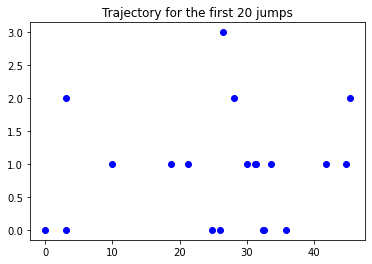

In [14]:
# 1st approach: global clock with rate w_star and matrix Q

# set the number of steps in the simulation
n_steps = 1000
# pos will keep trace of the visited states
pos = np.zeros(n_steps, dtype=int)
# we start from state 0
pos[0] = 0
# transition_times will store the time instants at which
# jumps/transitions happen
transition_times = np.zeros(n_steps)
# the random time to wait for the next transition
# is drawn according to its distribution, discussed in Remark 2
# NOTE: in the formula for t_next we use w_star, the rate of the
# "global" Poisson clock
t_next = -np.log(np.random.rand())/w_star

# Compute the cumulative sums of the rows of Q
# for ex., if a = np.array([[1,2,3],
#                         [4,5,6]])
# np.cumsum(a, axis=1) gives array([[ 1,  3,  6],
#                                   [ 4,  9, 15]])
Q_cum = np.cumsum(Q, axis=1)

for i in range(1,n_steps):
    # the next state to visit will be extracted according to the probabilities
    # stored in the row of Q corresponding to the current state.
    # In general, to extract a value pos[i] in (0,...,num_states-1) according to the discrete
    # distribution Q[pos[i-1],:], you can extract a random number in [0,1] and compare it with 
    # the cumulative sums Q_cum[pos[i-1]]. You then pick the first (smallest) state for which
    # the cumulative sum is grater than the random number.
    pos[i] = np.argwhere(Q_cum[pos[i-1]] > np.random.rand())[0]
    # store the time instant of the current transition
    transition_times[i] = transition_times[i-1] + t_next
    # compute the waiting time to the next transition
    t_next = -np.log(np.random.rand())/w_star

import matplotlib.pyplot as plt

# plot the trajectory for the first 20 jumps
plt.plot(transition_times[0:20], pos[0:20], 'bo')
plt.title('Trajectory for the first 20 jumps')

# Estimate pi

pi_estimate = np.zeros(4)
# We have the time instants of all transitions, we now compute time intervals.
# np.diff computes the n-th discrete difference of a vector.
# Here we set n=1 to compute first difference, which is given by 
# intervals[i] = transition_times[i+1] - transition_times[i].
# We also provide a value to  append to transition_times prior to performing the difference
# so that we can compute also the last interval: 
# transition_times[-1] + t_next is the end of the time horizon.
intervals = np.diff(transition_times, n=1, append = transition_times[-1] + t_next)

# for each state in the state space
for state in range(4):
    # identify the steps when we visited that state during the process
    visits = np.argwhere(pos == state)
    # the estimate of the invariant measure for that state is equal to the
    # time spent on the state divided the total time of the process
    pi_estimate[state] = np.sum(intervals[visits])/(transition_times[-1] + t_next)
    
print("Estimate of pi_bar:", pi_estimate)

Estimate of pi_bar: [0.21171701 0.35633495 0.37167815 0.06026989]


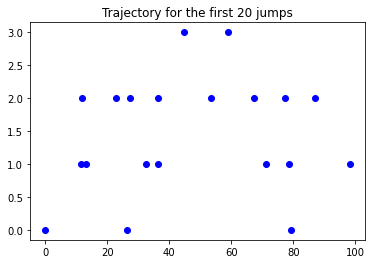

In [15]:
# 2nd approach: local clocks with rates w_i and matrix P

# contruct the P matrix and clocl rates w
w = np.sum(Lambda, axis=1)
D = np.diag(w)
P = np.linalg.inv(D) @ Lambda

# set the number of steps in the simulation
n_steps = 1000
# pos will keep trace of the visited states
pos = np.zeros(n_steps, dtype=int)
# we start from state 0
pos[0] = 0
# transition_times will store the time instants at which
# jumps/transitions happen
transition_times = np.zeros(n_steps)
# the random time to wait for the next transition
# is drawn according to its distribution, discussed in Remark 2
# NOTE: in the formula for t_next we use the rate of the clock of 
# the current state, in this case w[0].
t_next = -np.log(np.random.rand())/w[0]

# Compute the cumulative sums of the rows of P
P_cum = np.cumsum(P, axis=1)

for i in range(1,n_steps):
    # the next state to visit will be extracted according to the probabilities
    # stored in the row of P corresponding to the current state.
    pos[i] = np.argwhere(P_cum[pos[i-1]] > np.random.rand())[0]
    # store the time instant of the current transition
    transition_times[i] = transition_times[i-1] + t_next
    # compute the waiting time to the next transition
    # NOTE: we use the rate w[pos[i]] of the clock of the current position
    t_next = -np.log(np.random.rand())/w[pos[i]]

import matplotlib.pyplot as plt

# plot the trajectory for the first 20 jumps
plt.plot(transition_times[0:20], pos[0:20], 'bo')
plt.title('Trajectory for the first 20 jumps')

# Estimate pi

pi_estimate = np.zeros(4)

intervals = np.diff(transition_times, n=1, append = transition_times[-1] + t_next)
for node in range(4):
    visits = np.argwhere(pos == node)
    pi_estimate[node] = np.sum(intervals[visits])/(transition_times[-1] + t_next)
print("Estimate of pi_bar:", pi_estimate)

3. An ice-cream shop’s profit depends on the weather. Their profit per time unit is given by the following function
$$
f(X) = \begin{cases} 
10 & \text{if X = sunny}\\
2 & \text{if X = cloudy}\\
1 & \text{if X = rainy}\\
0 & \text{if X = snowy}
\end{cases}
$$
Simulate how the profit grows with time. Compute the average profit, both from the simulation and from the stationary distribution $\bar{\pi}$.

In [16]:
# Simulation of profit growth
# I choose to simulate the CTMC following the first approach

# set the number of steps in the simulation
n_steps = 1000
# payoff values corresponding to each state
payoff = [10, 2, 1, 0]

pos = np.zeros(n_steps, dtype=int)
pos[0] = 0
transition_times = np.zeros(n_steps)
# since I'm following the first simulation approach, here I divide by the rate
# w_star of the global clock
t_next = -np.log(np.random.rand())/w_star
# we define a profit variable, which stores the comulative profit up to
# the current time. For the first interval, which is t_next long, 
# the profit grows by payoff[pos[0]]*t_next
profit = payoff[pos[0]]*t_next

Q_cum = np.cumsum(Q, axis=1)

# we evolve the process as done before, increasing at each step the total profit
for i in range(1,n_steps):
    pos[i] = np.argwhere(Q_cum[pos[i-1]] > np.random.rand())[0]
    transition_times[i] = transition_times[i-1] + t_next
    # compute the waiting time to the next transition
    # NOTE: we use the rate w[pos[i]] of the clock of the current position
    t_next = -np.log(np.random.rand())/w_star
    # during the next interval, which is t_next long, the process will be in state
    # pos[i] and the profit will grow by payoff[pos[i]]*t_next
    profit = profit + payoff[pos[i]]*t_next
    
# the average profit is estimated as the overall profit obtained along the
# simulation divided by the total time of the process
average_profit = profit/(transition_times[-1] + t_next)
print("Average profit", average_profit)

Average profit 2.6564216074185043


Compare with the average payoff of the invariant distribution, computed as 
$$
\bar{f} = \sum_{X \in \mathcal X} f(X)\bar{\pi}_X
$$

In [ ]:
# TO DO